### Be in the folder Package when opening this notebook

In [3]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from scipy import signal

def gkern(kernlen=34, nsig=5.5):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=nsig).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def kernel_from_d(d_um=2.2, scaling_factor=0.345):
    '''
    d_um=2.2 # micrometer, smallest feature we want to detect
    scaling_factor=0.345 #pixela/um
    d=d_um/scaling_factor #d in pixels
    sigma=d*0.5*np.sqrt(3) # estimate of a good sigma to use Guesebroek et al.
    cutoff=2*np.ceil(3*sigma)
    '''
    d = d_um/scaling_factor  # d in pixels
    # estimate of a good sigma to use Guesebroek et al.
    sigma = d*0.5*np.sqrt(3)
    #print(sigma)
    cutoff = int(2*np.ceil(3*sigma)+1)
    #print(cutoff)
    kernel = np.array(gkern(kernlen=cutoff, nsig=sigma))

    return kernel, sigma, cutoff

def GD_metric(in_img, d_um=2.2, scaling_factor=0.345,g_gradient_x=None, g_gradient_y=None):
    '''input img in openCV format
    d_um is smallest feature detectable in image (resolution)
    g_gradient_x if provided is the kernel used in x, otherwise calculated from d_um
    g_gradient_y if provided is the kernel used in y, otherwise calculated from d_um

    return metric, filtered
    Method from 

    Shah et. al, Identification of Robust Focus Measure Functions for the Automated Capturing of Focused Images from
     Ziehl-Neelsen Stained Sputum Smear Microscopy Slide

     and 

    Geusebroek et. al, Robust Autofocusing in Microscopy

    code written and developed by H.Olof Jönsson 2020, please 
    credit (whatever paper we make) if using the code directly
    '''

    src = cv2.cvtColor(in_img, cv2.COLOR_BGR2GRAY)  # grayscale conversion
    # calculate kernel for x
    if g_gradient_x == None:
        kernel_2d, sigma, cutoff = kernel_from_d(d_um=d_um,scaling_factor=scaling_factor)
        g_gradient_x = np.gradient(kernel_2d, axis=1)

    # calculate kernel for y
    if g_gradient_y == None:
        kernel_2d, sigma, cutoff = kernel_from_d(d_um=d_um,scaling_factor=scaling_factor)
        g_gradient_y = np.gradient(kernel_2d, axis=0)

    # convolute with x kernel
    filtered_x = cv2.filter2D(src, cv2.CV_32S, g_gradient_x)
    # convolute with y kernel
    filtered_y = cv2.filter2D(src, cv2.CV_32S, g_gradient_y)

    filtered = np.add(np.square(filtered_x), np.square(
        filtered_y))  # squared sum of each pixel
    # sum of all pixels, divided by the total number of pixels
    metric = np.divide(np.sum(filtered), src.size)
    return metric, filtered


def plot_GD_result(filtered, metric, ax):
    im = ax.imshow(filtered, cmap='gray_r')
    plt.colorbar(im, ax=ax,fraction=0.026, pad=0.04)
    ax.set_title('Metric is {:.3f}'.format(metric))


def do_cutouts(path_to_image,
               threshold_fraction=0.15,
               closing_kernel=30,
               smallest_size_um2=120,
               d_um=2.2,
               scaling=0.345,
               show_diagnostics=False):
    '''input 
    path_to_image path to image to do cutouts from
    d_um is smallest feature detectable in image (resolution)
    closing_kernel is the size of the closing kernel in pixels. 
    smallest_size_um2 is the smallest area that will be cut out in um^2
    scaling is the size of pixels in um
    return_diagnostics if True will make a series of diagnostic plots
    

    The code will
    1) load the image
    2) calculate the gauusian derivative in each point, using sigma calculated from d_um and scaling
    3) use the treshold fractio threshold_fraction together with a closing algorithm with size closing_kernel to determine contours
    4) Cutout a rectangle around the outermost contours larger than smallest_size_um2
    
    Gaussian derivative method from 
    Shah et. al, Identification of Robust Focus Measure Functions for the Automated Capturing of Focused Images from
     Ziehl-Neelsen Stained Sputum Smear Microscopy Slide
     and 
    Geusebroek et. al, Robust Autofocusing in Microscopy

    code written and developed by H.Olof Jönsson 2020, please 
    credit (whatever paper we make) if using the code directly
    
    
    return
    
    cuts
    metrics
    
    '''
    
    #load image
    image = cv2.imread(path_to_image)
    
    #calculate the focus metric
    metric, filtered = GD_metric(image,d_um=d_um)

    #calcualte the threshold value
    threshold=np.max(filtered)*threshold_fraction
    
    #apply thresholding, to get where the focus metric is significant
    as_integer_array=(filtered>threshold).astype('uint8')
    ret,thresh = cv2.threshold(as_integer_array,0,255,cv2.THRESH_BINARY)
    #apply closing of thresholds, to get more uniform shapes
    closing_kernel = np.ones((closing_kernel,closing_kernel), dtype=np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, closing_kernel)

    #Calculate the contours in the thresholded image
    contours,hierarchy=cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #Cut out a rectangle around the contours found, with "extra" on the sides
    cut_from=image.copy()
    cuts=[]
    metrics=[]
    
    extra=0.5
    
    for c_index,contour in enumerate(contours):
        #print(hierarchy[0,c_index,3])
        if True:
            x,y,w,h = cv2.boundingRect(contour)
            cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        #only consider outermost rectangle
        if hierarchy[0,c_index,3]<0:
            x,y,w,h = cv2.boundingRect(contour)

            #only do cutouts larger that this
            if w*h>(smallest_size_um2*scaling**2):
                cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
                y_min=int(y-extra*h)
                y_max=int(y+extra*h+h)
                x_min=int(x-extra*w)
                x_max=int(x+extra*w+w)
                image_i = cut_from[y_min:
                       y_max,
                       x_min:
                       x_max]
                cuts.append(image_i)
                metric,_=GD_metric(image_i)
                metrics.append(metric)
                
    if show_diagnostics==True:
        plt.figure(figsize=[10, 10])
        plot_GD_result(image, metric, plt.gca())            

        plt.figure(figsize=[10, 10])
        plt.title('After gaissian derivative filter, threshold in red')
        plt.contour(filtered,levels=[threshold],colors=['red'])
        plot_GD_result(filtered, metric, plt.gca())

        plt.figure(figsize=[10, 10])
        plt.title('distribution of focus metric')
        _=plt.hist(filtered.flatten(),bins=100)
        plt.plot([threshold,threshold],[0,plt.gca().get_ylim()[1]],c='red')
        plt.yscale('log')

        plt.figure(figsize=[10, 10])
        plt.title('after thresholding')
        plt.imshow(thresh,cmap='gray_r')

        plt.figure(figsize=[10, 10])
        plt.title('after closing')
        plt.imshow(closing,cmap='gray_r')
        
        
                
                
    return cuts,metrics
            

Examples_images/255kHz_48ulpermin-06012020112137-58.png


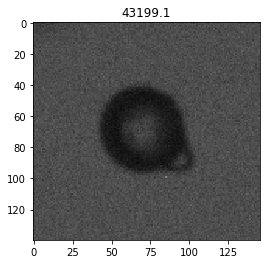

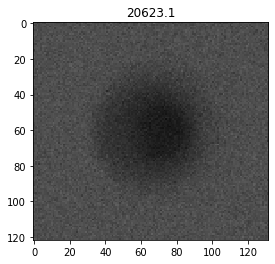

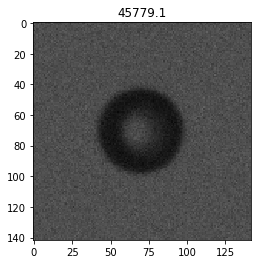

In [19]:
PATH = 'Examples_images/'
file_name='255kHz_48ulpermin-06012020112137-58.png'
#file_name = '255kHz_48ulpermin-06012020122747-5.png'
#file_name='255kHz_48ulpermin-06012020122750-15.png'

path_to_image = os.path.join(PATH, file_name)

print(path_to_image)
cuts,metrics=do_cutouts(path_to_image,show_diagnostics=False)

for cut_index,cut in enumerate(cuts):
    plt.figure()
    plt.imshow(cut,cmap='gray',vmin=0,vmax=255)
    #plt.colorbar()
    plt.title('{0:.1f}'.format(metrics[cut_index]))

In [9]:
pwd

'/Users/olofjonsson/Projects/Ice/Droplet_codes/Package'